In [1]:
!pip install -q -U datasets einops transformers peft bitsandbytes attrdict timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66

In [2]:
!git clone https://github.com/LLaVA-VL/LLaVA-NeXT.git

Cloning into 'LLaVA-NeXT'...
remote: Enumerating objects: 4568, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4568 (delta 206), reused 200 (delta 200), pack-reused 4350 (from 2)
Receiving objects: 100% (4568/4568), 119.10 MiB | 11.79 MiB/s, done.
Resolving deltas: 100% (3022/3022), done.


In [3]:
%cd LLaVA-NeXT
!git checkout inference

/content/LLaVA-NeXT
Branch 'inference' set up to track remote branch 'inference' from 'origin'.
Switched to a new branch 'inference'


In [5]:
%%writefile /content/LLaVA-NeXT/llava/model/builder.py
import os
import warnings
import shutil

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig
import torch
from llava.model import *
from llava.constants import DEFAULT_IMAGE_PATCH_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.utils import rank0_print


def load_pretrained_model(model_path, model_base, model_name, load_8bit=False, load_4bit=False, device_map="auto", attn_implementation="flash_attention_2", customized_config=None, **kwargs):
    kwargs = {"device_map": device_map}

    if load_8bit:
        kwargs["load_in_8bit"] = True
    elif load_4bit:
        # kwargs["load_in_4bit"] = True
        kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4")
    else:
        kwargs["torch_dtype"] = torch.float16

    if customized_config is not None:
        kwargs["config"] = customized_config

    if "llava" in model_name.lower():
        # Load LLaVA model
        if "lora" in model_name.lower() and model_base is None:
            warnings.warn(
                "There is `lora` in model name but no `model_base` is provided. If you are loading a LoRA model, please provide the `model_base` argument. Detailed instruction: https://github.com/haotian-liu/LLaVA#launch-a-model-worker-lora-weights-unmerged."
            )
        if "lora" in model_name.lower() and model_base is not None:
            lora_cfg_pretrained = AutoConfig.from_pretrained(model_path)
            tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
            rank0_print("Loading LLaVA from base model...")
            if "mixtral" in model_name.lower():
                from llava.model.language_model.llava_mixtral import LlavaMixtralConfig

                lora_cfg_pretrained = LlavaMixtralConfig.from_pretrained(model_path)
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                model = LlavaMixtralForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=lora_cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            elif "mistral" in model_name.lower():
                from llava.model.language_model.llava_mistral import LlavaMistralConfig

                lora_cfg_pretrained = LlavaMistralConfig.from_pretrained(model_path)
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                model = LlavaMistralForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=lora_cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            elif "gemma" in model_name.lower():
                from llava.model.language_model.llava_gemma import LlavaGemmaConfig

                lora_cfg_pretrained = LlavaGemmaConfig.from_pretrained(model_path)
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                model = LlavaGemmaForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=lora_cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            else:
                from llava.model.language_model.llava_llama import LlavaConfig

                lora_cfg_pretrained = LlavaConfig.from_pretrained(model_path)
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                model = LlavaLlamaForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=lora_cfg_pretrained, attn_implementation=attn_implementation, **kwargs)

            token_num, tokem_dim = model.lm_head.out_features, model.lm_head.in_features
            if model.lm_head.weight.shape[0] != token_num:
                model.lm_head.weight = torch.nn.Parameter(torch.empty(token_num, tokem_dim, device=model.device, dtype=model.dtype))
                model.model.embed_tokens.weight = torch.nn.Parameter(torch.empty(token_num, tokem_dim, device=model.device, dtype=model.dtype))

            rank0_print("Loading additional LLaVA weights...")
            if os.path.exists(os.path.join(model_path, "non_lora_trainables.bin")):
                non_lora_trainables = torch.load(os.path.join(model_path, "non_lora_trainables.bin"), map_location="cpu")
            else:
                # this is probably from HF Hub
                from huggingface_hub import hf_hub_download

                def load_from_hf(repo_id, filename, subfolder=None):
                    cache_file = hf_hub_download(repo_id=repo_id, filename=filename, subfolder=subfolder)
                    return torch.load(cache_file, map_location="cpu")

                non_lora_trainables = load_from_hf(model_path, "non_lora_trainables.bin")
            non_lora_trainables = {(k[11:] if k.startswith("base_model.") else k): v for k, v in non_lora_trainables.items()}
            if any(k.startswith("model.model.") for k in non_lora_trainables):
                non_lora_trainables = {(k[6:] if k.startswith("model.") else k): v for k, v in non_lora_trainables.items()}
            model.load_state_dict(non_lora_trainables, strict=False)

            from peft import PeftModel

            rank0_print("Loading LoRA weights...")
            model = PeftModel.from_pretrained(model, model_path)
            rank0_print("Merging LoRA weights...")
            model = model.merge_and_unload()
            rank0_print("Model is loaded...")
        elif model_base is not None:
            # this may be mm projector only
            rank0_print(f"Loading LLaVA from base model {model_base}...")
            if "mixtral" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                cfg_pretrained = AutoConfig.from_pretrained(model_path)
                model = LlavaMixtralForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            elif "mistral" in model_name.lower() or "zephyr" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                cfg_pretrained = AutoConfig.from_pretrained(model_path)
                model = LlavaMistralForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            elif "gemma" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                cfg_pretrained = AutoConfig.from_pretrained(model_path)
                model = LlavaGemmaForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            elif (
                "wizardlm-2" in model_name.lower()
                and "vicuna" in model_name.lower()
                or "llama" in model_name.lower()
                or "yi" in model_name.lower()
                or "nous-hermes" in model_name.lower()
                or "llava-v1.6-34b" in model_name.lower()
                or "llava-v1.5" in model_name.lower()
            ):
                from llava.model.language_model.llava_llama import LlavaConfig

                tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
                if customized_config is None:
                    llava_cfg = LlavaConfig.from_pretrained(model_path)
                    if "v1.5" in model_name.lower():
                        llava_cfg.delay_load = True  # a workaround for correctly loading v1.5 models
                else:
                    llava_cfg = customized_config

                tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
                llava_cfg = LlavaConfig.from_pretrained(model_path)
                model = LlavaLlamaForCausalLM.from_pretrained(model_base, low_cpu_mem_usage=True, config=llava_cfg, **kwargs)
            else:
                raise ValueError(f"Model {model_name} not supported")

            mm_projector_weights = torch.load(os.path.join(model_path, "mm_projector.bin"), map_location="cpu")
            mm_projector_weights = {k: v.to(torch.float16) for k, v in mm_projector_weights.items()}
            model.load_state_dict(mm_projector_weights, strict=False)
        else:
            rank0_print(f"Loaded LLaVA model: {model_path}")
            if "mixtral" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = LlavaMixtralForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, attn_implementation=attn_implementation, **kwargs)
            elif "mistral" in model_name.lower() or "zephyr" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = LlavaMistralForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, attn_implementation=attn_implementation, **kwargs)
            elif (
                "wizardlm-2" in model_name.lower()
                and "vicuna" in model_name.lower()
                or "llama" in model_name.lower()
                or "yi" in model_name.lower()
                or "nous-hermes" in model_name.lower()
                or "llava-v1.6-34b" in model_name.lower()
                or "llava-v1.5" in model_name.lower()
            ):
                from llava.model.language_model.llava_llama import LlavaConfig

                tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
                if customized_config is None:
                    llava_cfg = LlavaConfig.from_pretrained(model_path)
                    if "v1.5" in model_name.lower():
                        llava_cfg.delay_load = True  # a workaround for correctly loading v1.5 models
                else:
                    llava_cfg = customized_config

                model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, attn_implementation=attn_implementation, config=llava_cfg, **kwargs)
            elif "qwen" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
                print(kwargs)
                model = LlavaQwenForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, attn_implementation=attn_implementation, **kwargs)
            elif "gemma" in model_name.lower():
                tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
                cfg_pretrained = AutoConfig.from_pretrained(model_path)
                model = LlavaGemmaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, config=cfg_pretrained, attn_implementation=attn_implementation, **kwargs)
            else:
                rank0_print("\n\n\nWarning : No matching llava architecture, auto load llava_llama. If it is not intended, specify it in model_name\n\n\n")
                try:
                    from llava.model.language_model.llava_llama import LlavaConfig

                    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
                    if customized_config is None:
                        llava_cfg = LlavaConfig.from_pretrained(model_path)
                        if "v1.5" in model_path.lower():
                            llava_cfg.delay_load = True  # a workaround for correctly loading v1.5 models
                    else:
                        llava_cfg = customized_config
                    model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, attn_implementation=attn_implementation, config=llava_cfg, **kwargs)
                except:
                    raise ValueError(f"Model {model_name} not supported")

    else:
        # Load language model
        if model_base is not None:
            # PEFT model
            from peft import PeftModel

            tokenizer = AutoTokenizer.from_pretrained(model_base, use_fast=False)
            model = AutoModelForCausalLM.from_pretrained(model_base, torch_dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto")
            print(f"Loading LoRA weights from {model_path}")
            model = PeftModel.from_pretrained(model, model_path)
            print(f"Merging weights")
            model = model.merge_and_unload()
            print("Convert to FP16...")
            model.to(torch.float16)
        else:
            use_fast = False
            if "mpt" in model_name.lower().replace("prompt", ""):
                tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
                model = AutoModelForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, trust_remote_code=True, **kwargs)
            else:
                tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
                model = AutoModelForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)

    rank0_print(f"Model Class: {model.__class__.__name__}")
    image_processor = None

    if "llava" in model_name.lower():
        mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
        mm_use_im_patch_token = getattr(model.config, "mm_use_im_patch_token", True)
        if mm_use_im_patch_token:
            tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
        if mm_use_im_start_end:
            tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)
        model.resize_token_embeddings(len(tokenizer))

        vision_tower = model.get_vision_tower()
        if not vision_tower.is_loaded:
            vision_tower.load_model(device_map=device_map)
        if device_map != "auto":
            vision_tower.to(device="cuda", dtype=torch.float16)
        image_processor = vision_tower.image_processor

    if hasattr(model.config, "max_sequence_length"):
        context_len = model.config.max_sequence_length
    elif hasattr(model.config, "max_position_embeddings"):
        context_len = model.config.max_position_embeddings
    elif hasattr(model.config, "tokenizer_model_max_length"):
        context_len = model.config.tokenizer_model_max_length
    else:
        context_len = 2048

    return tokenizer, model, image_processor, context_len

Overwriting /content/LLaVA-NeXT/llava/model/builder.py


In [1]:
import dataclasses
from typing import Tuple, Any, List, Dict
import math
import os
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image
import cv2
import bitsandbytes as bnb

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('/content/LLaVA-NeXT')
from llava import conversation as conversation_lib
from llava.constants import DEFAULT_IMAGE_TOKEN
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## 1. Configs

In [2]:
N_EPOCHS = 20
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 1#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = False#True
GRAD_ACCUM_STEPS = 4
AMP_DTYPE = torch.float16
dtype = torch.float16
llm_dtype = torch.float16
# AMP_DTYPE = torch.bfloat16
# dtype = torch.bfloat16
# llm_dtype = torch.bfloat16

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Load MLLM Tokenizer and Model

In [4]:
model_path = 'lmms-lab/llava-next-interleave-qwen-0.5b'
model_base = None
model_name = 'llava-next-interleave-qwen-0.5b'
load_8bit = False
load_4bit = True

tokenizer, llm_model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name, load_8bit, load_4bit, attn_implementation=None)

{'device_map': 'auto', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
}


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


## 3. Prepare Dataset

In [5]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list])['train']

In [6]:
# hf_dataset_posi = hf_dataset
hf_dataset_sampled = hf_dataset.select(range(1000))

In [7]:
hf_dataset_sampled

Dataset({
    features: ['jpg', 'json', '__key__', '__url__'],
    num_rows: 1000
})

In [8]:
def preprocess_data(examples, conv_mode='qwen_1_5'):
    prompt_str_list = []
    image_tensor_list = []
    for image, prompt in zip(examples['jpg'], [d['prompt'] for d in examples['json']]):
        question = 'describe the image'
        # to test compatibility with video training, use same image twice (simulate video n_frames=2)
        n_images = 2
        conversation = conv_templates[conv_mode].copy()
        conversation.append_message(
            conversation.roles[0],
            DEFAULT_IMAGE_TOKEN * n_images + "\n" + question
        )
        conversation.append_message(conversation.roles[1], '> ' + prompt)
        prompt = conversation.get_prompt()

        pil_images = [image, image]  # use same image twice
        image_tensor = [image_processor.preprocess(pil_img, return_tensors="pt")["pixel_values"][0].to(llm_dtype).to(device) for pil_img in pil_images]
        image_tensor = torch.stack(image_tensor)

        prompt_str_list.append(prompt)
        image_tensor_list.append(image_tensor)

    examples["prompt_str"] = prompt_str_list
    examples["pixel_values"] = image_tensor_list

    return examples


def pad_input_ids(input_ids, max_seq_len, pad_token_id=tokenizer.pad_token_id):
    assert input_ids.ndim == 1
    n_pad = max_seq_len - len(input_ids)
    if n_pad > 0:
        pad_ids = torch.ones(n_pad, dtype=torch.long) * pad_token_id
        input_ids = torch.cat([input_ids, pad_ids], dim=0)
    attenton_mask = torch.ones_like(input_ids).long()
    attenton_mask[input_ids == pad_token_id] = 0
    return input_ids, attenton_mask


def batch_vl_emb(prompt_str_list, pixel_values_list, n_expand_image_tokens_per_image=729, image_token='<image>'):
    input_ids_list = []
    for prompt_str in prompt_str_list:
        input_ids = tokenizer_image_token(prompt_str, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").to(llm_model.device)
        input_ids_list.append(input_ids)

    max_seq_len = max([len(input_ids) for input_ids in input_ids_list])
    inputs_embeds_list = []
    attention_mask_list = []
    padded_input_ids_list = []
    for input_ids, pixel_values in zip(input_ids_list, pixel_values_list):
        input_ids_padded, attention_mask = pad_input_ids(input_ids, max_seq_len)
        input_ids_padded = input_ids_padded.unsqueeze(0)
        attention_mask = attention_mask.unsqueeze(0)
        position_ids = None
        (input_ids, position_ids, attention_mask, _, inputs_embeds, _) = llm_model.prepare_inputs_labels_for_multimodal(
            input_ids_padded, position_ids, attention_mask, None, None, pixel_values, image_sizes=None
        )
        inputs_embeds_list.append(inputs_embeds)
        attention_mask_list.append(attention_mask)
        padded_input_ids_list.append(input_ids_padded)
    inputs_embeds = torch.cat(inputs_embeds_list, dim=0)
    attention_mask = torch.cat(attention_mask_list, dim=0)
    padded_input_ids = torch.cat(padded_input_ids_list, dim=0)

    image_token_expanded_input_ids_list = []
    for prompt_str in prompt_str_list:
        input_ids = tokenizer_image_token(
            prompt_str.replace(image_token, n_expand_image_tokens_per_image * image_token),
            tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
        ).to(llm_model.device).unsqueeze(0)
        image_token_expanded_input_ids_list.append(input_ids)
    image_token_expanded_input_ids = torch.cat(image_token_expanded_input_ids_list, dim=0)
    assert image_token_expanded_input_ids.shape[1] == inputs_embeds.shape[1], (image_token_expanded_input_ids.shape[1], inputs_embeds.shape[1])

    return inputs_embeds, attention_mask, image_token_expanded_input_ids


def collate_fn(examples):
    prompt_str_list = [example["prompt_str"] for example in examples]
    pixel_values_list = [example["pixel_values"] for example in examples]
    inputs_embeds, attention_mask, input_ids = batch_vl_emb(prompt_str_list, pixel_values_list)
    inputs_embeds = inputs_embeds.to(device)
    attention_mask = attention_mask.to(device)
    input_ids = input_ids.to(device)

    image_token_expanded_len = inputs_embeds.shape[1] - input_ids.shape[1]

    loss_target_pos_mask = torch.zeros_like(attention_mask).to(device)
    end_of_non_prediction_target_token = tokenizer.encode('>')[-1]
    loss_target_start_idx = (input_ids == end_of_non_prediction_target_token).long().argmax(dim=-1) + 1 + image_token_expanded_len
    # print(loss_target_start_idx, image_token_expanded_len)
    for i in range(len(loss_target_start_idx)):
        loss_target_pos_mask[i, loss_target_start_idx[i]:] = 1

    return {
        "inputs_embeds": inputs_embeds,
        "attention_mask": attention_mask,
        "input_ids": input_ids,
        "loss_target_pos_mask": loss_target_pos_mask,
    }

In [9]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 198 ms, sys: 11.1 ms, total: 209 ms
Wall time: 209 ms


In [12]:
_d = hf_dataset_sampled[0]

In [13]:
_d.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'prompt_str', 'pixel_values'])

In [14]:
_d[ 'prompt_str']

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image><image>\ndescribe the image<|im_end|>\n<|im_start|>assistant\n> A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.<|im_end|>\n'

In [15]:
_d['pixel_values'].shape

torch.Size([2, 3, 384, 384])

In [10]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [11]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TEST_BATCH_SIZE,
)

In [18]:
_batch = next(iter(train_dataloader))

In [19]:
_batch.keys()

dict_keys(['inputs_embeds', 'attention_mask', 'input_ids', 'loss_target_pos_mask'])

In [20]:
_batch['inputs_embeds'].shape, _batch['attention_mask'].shape, _batch['input_ids'].shape, _batch['loss_target_pos_mask'].shape

(torch.Size([1, 1530, 1024]),
 torch.Size([1, 1530]),
 torch.Size([1, 1530]),
 torch.Size([1, 1530]))

In [21]:
tokenizer.batch_decode(_batch['input_ids'].clip(0))

['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [22]:
tokenizer.batch_decode(_batch['input_ids'].clip(0) * _batch['loss_target_pos_mask'])

['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## 4. Model

In [12]:
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     bnb_8bit_compute_dtype=llm_dtype,
# )
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    # bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=llm_dtype,
)

In [13]:
llm_model.dtype, llm_dtype

(torch.float16, torch.float16)

In [14]:
llm_model.model

LlavaQwenModel(
  (embed_tokens): Embedding(151646, 1024)
  (layers): ModuleList(
    (0-23): 24 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
        (o_proj): Linear4bit(in_features=1024, out_features=1024, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear4bit(in_features=1024, out_features=2816, bias=False)
        (up_proj): Linear4bit(in_features=1024, out_features=2816, bias=False)
        (down_proj): Linear4bit(in_features=2816, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((1024,), eps=1e-06)
  (rotary_emb): Qwen2RotaryEmbedding()
  (vision_tower)

In [15]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

train_vision_module = False
if train_vision_module:
    target_modules = [
        f"q_proj",
        r"k_proj",
        r"v_proj",
        r"o_proj",
    ]
else:
    target_modules = sum([
        [
            f"model.layers.{layer}.self_attn.q_proj",
            f"model.layers.{layer}.self_attn.k_proj",
            f"model.layers.{layer}.self_attn.v_proj",
            f"model.layers.{layer}.self_attn.o_proj",
        ] for layer in range(24)
    ], [])
# target_modules += ["mm_projector"]

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM,
    target_modules=target_modules,
)

# llm_model.language_model.enable_input_require_grads()
# llm_model.language_model = prepare_model_for_kbit_training(llm_model.language_model)
llm_model = get_peft_model(llm_model, peft_config)
llm_model.print_trainable_parameters()

trainable params: 3,145,728 || all params: 866,815,520 || trainable%: 0.3629


In [16]:
llm_model.dtype, llm_dtype

(torch.float16, torch.float16)

In [17]:
# torch.save(llm_model.state_dict(), 'init_llm_model.pt')

In [18]:
llm_model.base_model.model.model.vision_tower

SigLipVisionTower(
  (vision_tower): SigLipVisionModel(
    (vision_model): SigLipVisionTransformer(
      (embeddings): SigLipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): SigLipEncoder(
        (layers): ModuleList(
          (0-25): 26 x SigLipEncoderLayer(
            (self_attn): SigLipAttention(
              (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SigLipMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear4bit(in_features

In [22]:
# _ = llm_model.vision_tower.requires_grad_(False)

In [19]:
for name, p in llm_model.named_parameters():
    if p.requires_grad:
        print(name, p.requires_grad)

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight True
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight True
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight True
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight True
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight True
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight True
base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight True
base_model.model.model.layers.1.self_attn.k_proj.lora_B.default.weight True
base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight True
base_model.m

In [20]:
train_models = [llm_model]

## 5. Training

In [21]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [22]:
def get_trainable_params(models):
    params = []
    for model in models:
        params += [p for p in model.parameters() if p.requires_grad]
    return params

In [23]:
# optimizer = torch.optim.AdamW(
optimizer = bnb.optim.AdamW8bit(
    # nn.ModuleList(train_models).parameters(),
    get_trainable_params(train_models),
    lr=LR, weight_decay=WEIGHT_DECAY
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1*len(train_dataloader),
    num_training_steps=N_EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device=device, enabled=USE_AMP)

In [24]:
loss_history = []
train_acc_history = []
test_acc_history = []

In [25]:
for epoch in range(N_EPOCHS):
    if epoch > 0:
        # Train phase
        [m.train() for m in train_models]
        epoch_loss = 0.0
        pred_labels = []
        true_labels = []
        metric_target_mask_list = []
        optimizer.zero_grad()
        for i, batch in enumerate(pb(train_dataloader)):
            batch = batch_to_device(batch, device)
            # pixel_values = batch.pop('pixel_values')
            loss_target_pos_mask = batch.pop('loss_target_pos_mask')
            target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
            target_labels[loss_target_pos_mask[:, :-1] == 0] = -100
            with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
                llm_out = llm_model(
                    inputs_embeds=batch['inputs_embeds'],
                    attention_mask=batch['attention_mask'],
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                loss = loss / GRAD_ACCUM_STEPS
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((loss_target_pos_mask * batch['attention_mask'])[:, :-1].cpu())
            scaler.scale(loss).backward()
            # loss.backward()
            if (i + 1) % GRAD_ACCUM_STEPS == 0:
                scaler.step(optimizer)
                # optimizer.step()
                scaler.update()
                optimizer.zero_grad()
            scheduler.step()
            epoch_loss += loss.cpu().detach()
        pred_labels_flat = torch.cat([l.flatten() for l in pred_labels], dim=0)
        true_labels_flat = torch.cat([l.flatten() for l in true_labels], dim=0)
        metric_target_mask_flat = torch.cat([m.flatten() for m in metric_target_mask_list], dim=0)
        acc = ((pred_labels_flat == true_labels_flat).long() * metric_target_mask_flat.cpu()).sum() / metric_target_mask_flat.sum()
        train_acc_history.append(acc)
        loss_history.append(epoch_loss / len(train_dataloader))
        print(f'epoch {epoch} : loss {loss_history[-1]} : acc {acc}')

        gt_texts = sum([tokenizer.batch_decode(true_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
        pred_texts = sum([tokenizer.batch_decode(pred_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
        gt_texts = [t.replace('!', '') for t in gt_texts]
        pred_texts = [t.replace('!', '') for t in pred_texts]
        print('train gt txt : \n', '\n'.join(gt_texts))
        print('train pred txt : \n', '\n'.join(pred_texts))

    # Ealuluation Phase
    [m.eval() for m in train_models]
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    with torch.inference_mode():
        for batch in pb(test_dataloader):
            batch = batch_to_device(batch, device)
            # pixel_values = batch.pop('pixel_values')
            loss_target_pos_mask = batch.pop('loss_target_pos_mask')
            target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
            target_labels[loss_target_pos_mask[:, :-1] == 0] = -100
            optimizer.zero_grad()
            with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
                llm_out = llm_model(
                    inputs_embeds=batch['inputs_embeds'],
                    attention_mask=batch['attention_mask'],
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((loss_target_pos_mask * batch['attention_mask'])[:, :-1].cpu())
    pred_labels_flat = torch.cat([l.flatten() for l in pred_labels], dim=0)
    true_labels_flat = torch.cat([l.flatten() for l in true_labels], dim=0)
    metric_target_mask_flat = torch.cat([m.flatten() for m in metric_target_mask_list], dim=0)
    acc = ((pred_labels_flat == true_labels_flat).long() * metric_target_mask_flat.cpu()).sum() / metric_target_mask_flat.sum()
    test_acc_history.append(acc)
    print(f'epoch {epoch} : test acc {test_acc_history[-1]}')

    gt_texts = sum([tokenizer.batch_decode(true_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
    pred_texts = sum([tokenizer.batch_decode(pred_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
    gt_texts = [t.replace('!', '') for t in gt_texts]
    pred_texts = [t.replace('!', '') for t in pred_texts]
    print('test gt txt : \n', '\n'.join(gt_texts))
    print('test pred txt : \n', '\n'.join(pred_texts))

    print(scheduler.get_lr())

    torch.cuda.empty_cache()

epoch 0 : test acc 0.6278659701347351
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  image of a book "M Puzo Omnerta' by the black circle and the center. a text " author's in white white, white font. The

 cat-up of of a cat's sign. a white print on. The card is a red background with white text. reads "IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a list labeled thePET NAME', followedCONTACT', and 'CONTACTERGENCYCONTACT'. The card has placed on a reded rug with a red design. The

[0.0]


epoch 1 : loss 0.3360461890697479 : acc 0.6455574631690979
train gt txt : 
  man is standing in a white studio wearing a black suit with a white shirt and black tie.<|im_end|>

 black and pink floral patterned handbag with a long strap is lying on a wooden surface. The handbag is open, revealing its interior, and there are playing cards scattered around it. The cards have a black and white design with a face card on each.<|im_end|>

train pred txt : 
  man standing standing against a white room background a black suit and a white shirt and black tie. He

 black purse pink floral baged pursebag with a gold zipper. placed on a wooden surface. There bagbag has open, revealing a interior. which there are four cards on around it. The playing have a black and white color with a pink-up and the side The



epoch 1 : test acc 0.6708353161811829
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  image of a book 'M Puzo Omnerta' by the red circular and the center and the title ' author's in white smaller, white font. The

 red-up of of a red's tag with a cat print on on The card is a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the card, there are a list with 'PET NAME', followedCONTACT', and 'CONTACTERGENCYCONTACT'. The card is placed on a reded rug with a red design.<|im_end|>

[5e-05]


epoch 2 : loss 0.2956269085407257 : acc 0.6759704947471619
train gt txt : 
  mannequin head with a bald scalp is wearing a blue and red American flag patterned mask with a black strap. The mask has a silver buckle in the center and is secured with a black buckle on the chin. The mannequin has large, expressive eyes and a neutral expression.<|im_end|>

 close-up image of a black eyeshadow compact with a circular design and a black cap on top. The compact is placed against a white background with a 'ROCK IN' text at the bottom left corner and a '100+ UNDER $100' text at the bottom right corner.<|im_end|>

train pred txt : 
  mannequin wearing wearing a white head and wearing a face and red face flag masked face with a circular nose. The mask has a circular button on the center and a attached with a black strap on the left. The mannequin has blue, round blue and a neutral expression.<|im_end|>

 close-up of of a compact compacteshadow palette with a black lid and a transparent lid. top. T

epoch 2 : test acc 0.678371012210846
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  image of a book 'M Puzo'serto' by the red circular and the center and the title ' author's in white smaller, white font.<|im_end|>

 red-up of of a red's tag with a white print on on The card is a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a section with 'P NAME', followedCONTACT', and 'CONTACTERGENCYCONTACT'. The card is placed on a reded rug with a variety design.<|im_end|>

[4.965903258506806e-05]


epoch 3 : loss 0.2754863202571869 : acc 0.6906221508979797
train gt txt : 
  man with a beard and glasses is standing on a road with trees and a mountain in the background. He is wearing a black shirt and has a camera strap around his neck.<|im_end|>

 blue insulated thermos with a black cap and a silver button on top. The thermos has a textured surface and is labeled 'SKI OUTDOOR' in white letters.<|im_end|>

train pred txt : 
  man is a beard and glasses is standing on a road with a in a mountain in the background. He is wearing a black shirt with has a camera on around his neck.<|im_end|>

 blue water wateros with a black handle and a silver handle on the is<|im_end|> thermos is a sleek surface and is designed 'SK'DOOR'. in white text.<|im_end|>



epoch 3 : test acc 0.6855860352516174
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  cover of a book 'M Puzo'erto' by a red circular and the center and the title ' author's in white smaller, white font.<|im_end|>

 red-up of of a red's tag with a red print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a blank with 'PET NAME' followedCONTACT', and 'CONTACTERGENCYCONTACT'. The card has placed on a reded rug with a variety design.<|im_end|>

[4.864543104251587e-05]


epoch 4 : loss 0.25768470764160156 : acc 0.7058756947517395
train gt txt : 
  modern computer monitor with a black frame and a flat screen display is mounted on a wall bracket. The monitor is positioned at an angle, and there are two small black stands on the floor in front of it. The wall bracket has a black finish and is attached to the wall with screws.<|im_end|>

 complex maze with a blue and white color scheme is displayed. The maze is filled with numerous paths and dead ends, creating a challenging puzzle for the viewer to navigate. The maze is presented in a square format with a white border, and there are no visible exits or starting points.<|im_end|>

train pred txt : 
  black black monitor with a black frame and a black screen display is mounted on a black..<|im_end|> monitor has displaying in a angle, with there are two black black stands supporting the left next front of it.<|im_end|> floor bracket has a black base and is attached to the wall. two.<|im_end|>

 white maze wi

epoch 4 : test acc 0.6812570095062256
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo'erto' by a red circular and the center and a title ' author name in white white, white font. The

 red-up of of a red's tag with a red print design on The card is a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a red with 'PET NAME' followedCONTACT', and 'CONTACTERGENCYCONTACT'. The card is placed on a reded rug with a variety design.<|im_end|>

[4.698684378016222e-05]


epoch 5 : loss 0.23997697234153748 : acc 0.7228220105171204
train gt txt : 
  black and white image with a series of horizontal lines and a white square in the bottom left corner.<|im_end|>

 rural landscape with a dirt road running through it, flanked by grassy fields and a few trees. In the distance, there are several houses with blue roofs, and the terrain slopes upwards towards a hill. The sky is partly cloudy.<|im_end|>

train pred txt : 
  black and white image with a series of black lines that a diagonal background at the center right corner. The

 rural landscape with a dirt road running through it, surroundedanked by ay fields and a small trees. The the distance, there are houses houses with blue roofs and and the sky is gently, a hill with The sky is partly cloudy,<|im_end|>



epoch 5 : test acc 0.6815776824951172
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  cover of the book 'M Puzo'erto' by a red circle in the center and the title ' author name in white white, white font. The

 red-up of of a red's tag with a white print on on The card is a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red titled 'PET NAME' followedCONTACT', and 'CONTACTERGENCYCONTACT'. The card is placed on a reded carpet with a variety design.<|im_end|>

[4.4728512734909844e-05]


epoch 6 : loss 0.22249945998191833 : acc 0.7376993894577026
train gt txt : 
  promotional website page for a casino with a large golden 'Casino Action' logo at the top. The page features a prominent 'Gutschein' (coupon) offer with a red and gold design, offering a 125% bonus up to \xe2\x82\xac1250. Below the coupon, there is a 'Gutscheincode' (coupon code) section with a blue button that reads 'Erneuern und Speichern' (Renew and Save). The page also includes a 'Gutscheinbedingungen' (Coupon Conditions) section with a link to the terms and conditions. The website has a dark background with a golden and black<|im_end|>

 silver ruler with a protractor on the left side and a ruler on the right side, both with markings for measurements. The ruler is placed on a white background.<|im_end|>

train pred txt : 
  screenshot image for for a casino game a red red bannerCino Action' logo in the top. The page features a red 'GUT' textdiscount) offer with a discount and gold color, accompanied a 12

epoch 6 : test acc 0.6844636797904968
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  cover of the book 'M Puzo'erto' by a red circular and the center and the title ' author name in white white, white font.<|im_end|>

 red-up of of a red's tag with a red print design on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a red titled 'PET NAME' 'CONTACT', and 'CONTACTERGENCYCONTACT'. The card also placed on a reded carpet. a variety design.<|im_end|>

[4.193203929064353e-05]


epoch 7 : loss 0.20474357903003693 : acc 0.7549465894699097
train gt txt : 
  white hoodie with a red, white, and blue elephant graphic on the front.<|im_end|>

 man with dark hair and glasses is wearing a blue vest over a white shirt.<|im_end|>

train pred txt : 
  white hoodie with a graphic and blue, and blue elephant graphic on the front.<|im_end|>

 man with dark hair and glasses is wearing a blue vest over a white shirt.<|im_end|>



epoch 7 : test acc 0.6807760000228882
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white white, white font. The

 red-up of of a red's tag with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a red labeled 'PET NAME' 'CONTACT', and 'EMERGENCYCONTACT'. The card is placed on a reded carpet. a variety design.<|im_end|>

[3.867370395306068e-05]


epoch 8 : loss 0.18829262256622314 : acc 0.7716107368469238
train gt txt : 
  scenic view of a mountainous landscape with a clear blue sky. The image features a quote by Wayne Gretzky, which reads, 'Eight days ago, we were the toast of the town. Eight days later, we're thankful turkeys.' The quote is placed in the lower half of the image, with the mountains and sky occupying the upper half.<|im_end|>

 music sheet with the title 'WARM UP & PRACTICE SCALES FOR BAND' at the top. The sheet contains various musical notations and symbols, including notes, rests, and dynamics markings. The notations are arranged in a grid-like pattern with different sections labeled 'ALTO', 'BASS', 'CLARINET', 'FLUTE', 'OBOE', 'BASSOON', 'TRUMPET', 'TROMBONE', 'VIOLIN', 'VIOLA', 'CELLO', 'BASS', 'VIOLIN', 'VIOLA', 'CELLO', '<|im_end|>

train pred txt : 
  mountain view of a mountainous landscape with a clear blue sky. The mountains features a quote from Wayne Grzky, which reads ' 'Eight days ago, we were ev 

epoch 8 : test acc 0.6812570095062256
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white foreign, white font.<|im_end|>

 red-up of of a red's tag with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a red labeled 'PET NAME' 'CONTACT', and 'EMERGENCYCONTACT'. The card is placed on a reded carpet with a variety design.<|im_end|>

[3.504238561632424e-05]


epoch 9 : loss 0.17209769785404205 : acc 0.7889143824577332
train gt txt : 
  serene landscape featuring a group of sheep grazing on a lush green hillside with steep cliffs and towering mountains in the background. The sky is partly cloudy, and the overall atmosphere is calm and picturesque.<|im_end|>

 set of circuit boards is displayed on a white background. The boards have a grid pattern with various components and connections. There are five boards in total, with the largest one in the center and four smaller ones arranged around it. The boards are placed in a way that they appear to be stacked on top of each other, but they are not physically touching.<|im_end|>

train pred txt : 
  group landscape with a group of sheep grazing in a lush green hillside with a, and towering mountains in the background. The sky is partly cloudy, and the overall atmosphere is calm and id.<|im_end|>

 set of electronic boards is displayed on a white background. The boards are a variety pattern with va

epoch 9 : test acc 0.6713163256645203
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  cover of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white foreign, white font.<|im_end|>

 red-up of of a red's tag with a red print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a red labeled 'PET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card is placed on a reded carpet with a variety design.<|im_end|>

[3.1137137178519985e-05]


epoch 10 : loss 0.15790264308452606 : acc 0.8070268034934998
train gt txt : 
  silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<|im_end|>

 book cover with a greenish hue and a title that reads 'D. G. G. CHAMISCHI' in a foreign script. The cover features an illustration of two people, one on the left and one on the right, with the left person wearing a hat. The book is placed on a surface with a dark background.<|im_end|>

train pred txt : 
  silver cross pendant with a heart-shaped cutout in the center, adorned with diamonds diamonds, is displayed against a dark background.<|im_end|>

 vintage cover with a green and hue and a title that reads 'D.G G. G. CHAMPEHI' in a foreign script. The cover features a illustration of two men in one in each left and one on the right, both the person person on a hat. The book is placed on a table with a green background.<|im_end|>



epoch 10 : test acc 0.6725990176200867
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  cover of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's tag with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there are a red with 'PET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface with a variety design.<|im_end|>

[2.7064483636808313e-05]


epoch 11 : loss 0.14484341442584991 : acc 0.8247253894805908
train gt txt : 
  second image shows a close-up of a DJ's equipment, specifically the turntables and the mixer. The equipment is illuminated by colorful lights, creating a vibrant and dynamic scene. The turntables are positioned in the center, with the mixer to the right. The lights cast a spectrum of colors across the equipment, including red, blue, and purple hues. The background is dark, which highlights the illuminated equipment and creates a focal point for the viewer.<|im_end|>

 silver and black vintage camera with a red logo on the top and a silver lens cap on the front.<|im_end|>

train pred txt : 
  first image shows the close-up of a DJ's equipment, specifically a turntables and the DJ. The equipment is illuminated with a lights, creating a vibrant and dynamic scene. The turntables are in to the center, with the mixer to the left. The lights are a bright of colors on the equipment, including red, blue, and purple h

epoch 11 : test acc 0.6698733568191528
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  cover of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white foreign, white font. The

 red-up of of a red's sign with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with 'PET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface, a variety design.<|im_end|>

[2.2935516363191693e-05]


epoch 12 : loss 0.13369803130626678 : acc 0.8385871052742004
train gt txt : 
  stylized illustration of a group of characters from the anime series 'Naruto', with a pink and green color scheme. The characters are depicted in various poses and expressions, with some holding items like a book and a remote control. The image is adorned with Japanese text and symbols, and the characters are wearing outfits that resemble those from the anime series.<|im_end|>

 woman is sitting in a car with a blue interior, holding a gun in her right hand. She is smiling and looking directly at the camera. The car's window is partially open, and there is a yellow object on the window frame. The car's steering wheel is on the right side, and the woman is wearing a black top.<|im_end|>

train pred txt : 
  stylized illustration of a group of characters from the anime series 'Naruto' with a pink background green color scheme. The characters are depicted in a poses, expressions, with some holding items like a 

epoch 12 : test acc 0.6653839945793152
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white white font white font. The

 red-up of of a red's sign with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with 'PET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded carpet, a variety design.<|im_end|>

[1.8862862821480025e-05]


epoch 13 : loss 0.12423983216285706 : acc 0.851094663143158
train gt txt : 
  plain beige background with a series of horizontal lines, resembling a grid pattern. The lines are evenly spaced and run across the entire image, creating a uniform texture.<|im_end|>

 blue insulated thermos with a black cap and a silver button on top. The thermos has a textured surface and is labeled 'SKI OUTDOOR' in white letters.<|im_end|>

train pred txt : 
  plain beige background with a series of horizontal lines, resembling a grid pattern. The lines are evenly spaced and run horizontally the entire image, creating a uniform texture.<|im_end|>

 blue stainless wateros with a black cap and a silver button on top. The thermos has a smooth surface and is labeled 'SK OUTDOOR' in white letters.<|im_end|>



epoch 13 : test acc 0.6626583337783813
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white foreign, white font. The

 red-up of of a red's sign with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red titled thePET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface, a variety design.<|im_end|>

[1.495761438367577e-05]


epoch 14 : loss 0.11671619862318039 : acc 0.8620786666870117
train gt txt : 
  vehicle inspection worksheet with a blank space for the vehicle's make and model, and a section for the vehicle's address. The worksheet includes sections for the vehicle's description, business phone, and business address. There is also a section for the inspector's name and contact information. The worksheet is accompanied by a diagram of a car with a red X marking the location of a potential issue.<|im_end|>

 silver ruler with a protractor on the left side and a ruler on the right side, both with markings for measurements. The ruler is placed on a white background.<|im_end|>

train pred txt : 
  white inspection sheet with a blank page for the driver's make and model, as a section for the inspection's serial. The worksheet includes a for the vehicle's make, maintenance contact, and business address. There is also a section for the vehicle's name and contact information. The worksheet is laid by a black o

epoch 14 : test acc 0.6631393432617188
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red and and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's card with a white print on on The card has a red and with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with thePET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface surface a variety design.<|im_end|>

[1.1326296046939333e-05]


epoch 15 : loss 0.11074718087911606 : acc 0.8698089122772217
train gt txt : 
  beige, floor-length evening gown with a fitted bodice and a flared skirt, adorned with a sparkling silver sequin pattern. The gown features a high neckline, short sleeves, and a V-shaped back. The dress is accessorized with a matching silver belt around the waist.<|im_end|>

 red fire hydrant with a hose attached to it, and a red fire extinguisher with a hose attached to it, both on a white background.<|im_end|>

train pred txt : 
  beige dress shimmer-length wedding gown with a fitted bodice and a flared skirt, adorned with a sparkling, beltin pattern. The gown features a high neckline, short sleeves, and a V-neck back. The dress is accessorized with a silver silver belt around the waist.<|im_end|>

 red fire hydrant with a hose attached to it, and a red fire extinguisher with a hose attached to it, both on a white background.<|im_end|>



epoch 15 : test acc 0.6596119999885559
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red circle and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's sign with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with thePET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface, a variety design.<|im_end|>

[8.067960709356478e-06]


epoch 16 : loss 0.10627003014087677 : acc 0.8783667087554932
train gt txt : 
  black car with a license plate reading '2YV' is parked in a lot. The car has a sticker on the rear window with the word 'SALVAGE' written in white letters. The car's headlights are on, and the interior is visible through the windshield.<|im_end|>

 red fire hydrant with a hose attached to it, and a red fire extinguisher with a hose attached to it, both on a white background.<|im_end|>

train pred txt : 
  black car with a license plate reading '2YEN' is parked in a lot. The car has a sign on the window window with the word 'ALALVAGE' written in white letters. The car's headlights are on, and the interior is visible through the windows.<|im_end|>

 red fire hydrant with a hose attached to it, and a red fire extinguisher with a hose attached to it, both on a white background.<|im_end|>



epoch 16 : test acc 0.6588103175163269
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red and and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's sign with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with thePET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface surface a variety design.<|im_end|>

[5.271487265090163e-06]


epoch 17 : loss 0.10311029851436615 : acc 0.8816016912460327
train gt txt : 
  close-up of a blue carabiner with the word 'BUDGET' written in orange letters on its side. The carabiner is attached to a yellow rope with a metal clip. The background is a clear blue sky.<|im_end|>

 black and white vacuum cleaner with a long hose and a round base is displayed against a white background.<|im_end|>

train pred txt : 
  close-up of a blue andabiner with the word 'TOTTGET' written in orange on on its side. The carabiner is attached to a yellow rope with a metal clip. The background is a clear blue sky.<|im_end|>

 black and white vacuum cleaner with a long hose and a round base is displayed against a white background.<|im_end|>



epoch 17 : test acc 0.6578482985496521
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red and and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's sign with a white print on on The card has a red and with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with thePET NAME' followedCONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface surface a variety design.<|im_end|>

[3.013156219837776e-06]


epoch 18 : loss 0.1010136753320694 : acc 0.8840091824531555
train gt txt : 
  blue and white plastic comb with the brand name 'Wiffen' on the packaging is displayed against a white background. The comb is positioned vertically, and the packaging is in the shape of a rectangular box with a clear plastic window. The brand name 'Wiffen' is written in white letters on the packaging, and the comb itself has a series of teeth with a yellowish hue.<|im_end|>

 set of colorful, round, plastic tokens with various designs on them. The tokens are arranged in a 3x3 grid, with each token having a different color and design. The top row has tokens with a purple background and a yellow, green, and red design, respectively. The second row has tokens with a green background and a yellow, green, and red design, respectively. The third row has tokens with a red background and a yellow, green, and red design, respectively. The bottom row has tokens with a blue background and a yellow, green, and red desig

epoch 18 : test acc 0.6580086350440979
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red and and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's sign with a white print on on The card has a red background with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with thePET NAME' followedCONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface surface a variety design.<|im_end|>

[1.3545689574841342e-06]


epoch 19 : loss 0.09988050907850266 : acc 0.8861345052719116
train gt txt : 
  child wearing a green winter coat with a fur-lined hood and a yellow beanie stands in front of a mannequin displaying the same coat.<|im_end|>

 black digital wristwatch with a square face and a black strap is displayed against a white background. The watch has a digital display showing the time in black numbers on a black background. The watch has a black bezel and a black crown on the right side.<|im_end|>

train pred txt : 
  child wearing a green jacket coat with a fur hood hood and a yellow beanie stands in front of a mannequin displaying the same coat.<|im_end|>

 black wrist wristwatch with a square face and a black strap is displayed against a white background. The watch has a digital display showing the time in black digits with a black background. The watch has a black bezel and a black crown on the right side.<|im_end|>



epoch 19 : test acc 0.6578482985496521
test gt txt : 
  cover of the book 'Mario Puzo Omerta' with a red circle in the center and the title and author name in a bold, white font.<|im_end|>

 close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.<|im_end|>

test pred txt : 
  second of the book 'M Puzo:erto' by a red and and the center and the title ' author name in white foreign font white font. The

 red-up of of a red's sign with a white print on on The card has a red and with white text and reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. The the text, there is a red with thePET NAME' 'CONTACT', and 'EMERGENCYCONTACT' The card also placed on a reded surface surface a variety design.<|im_end|>

[3.4096741493194197e-07]


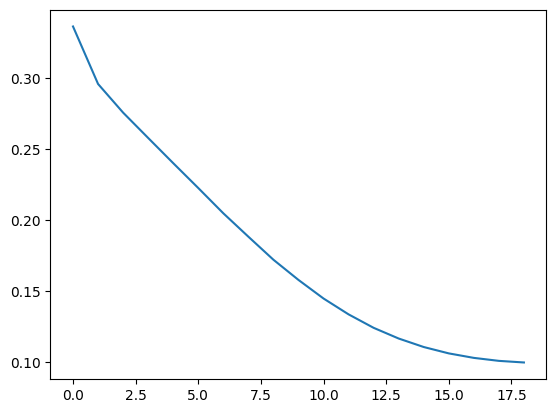

In [26]:
plt.plot(loss_history)

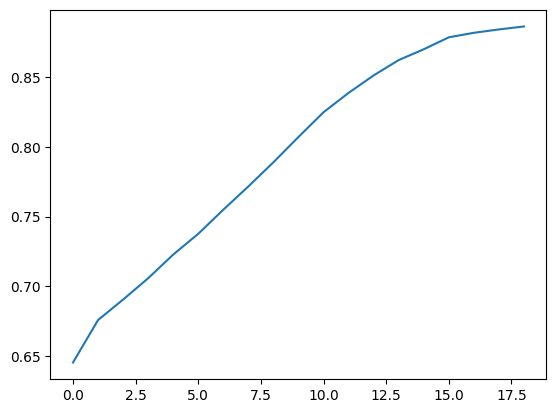

In [27]:
plt.plot(train_acc_history)

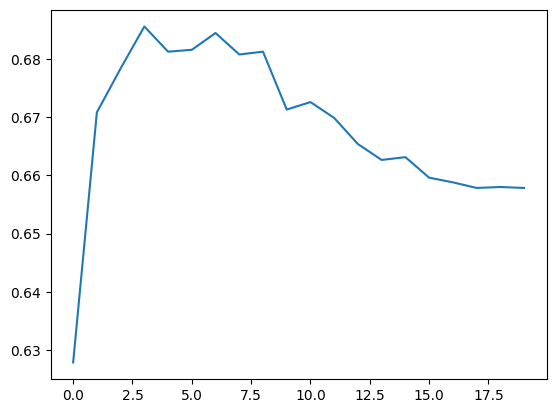

In [28]:
plt.plot(test_acc_history)

## 6. Generation with Trained Model

In [29]:
_ = [m.eval() for m in train_models]

In [30]:
@torch.inference_mode()
def generate(image, question = 'describe the image', conv_mode='qwen_1_5'):
    # to test compatibility with video training, use same image twice (simulate video n_frames=2)
    n_images = 2
    conversation = conv_templates[conv_mode].copy()
    conversation.append_message(
        conversation.roles[0],
        DEFAULT_IMAGE_TOKEN * n_images + "\n" + question
    )
    conversation.append_message(conversation.roles[1], '> ')
    prompt = conversation.get_prompt()

    pil_images = [image, image]  # use same image twice
    image_tensor = [image_processor.preprocess(pil_img, return_tensors="pt")["pixel_values"][0].to(llm_dtype).to(device) for pil_img in pil_images]
    image_tensor = torch.stack(image_tensor)

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(llm_model.device)

    position_ids = None
    attention_mask = None

    (inputs, position_ids, attention_mask, _, inputs_embeds, _) = llm_model.prepare_inputs_labels_for_multimodal(
        input_ids, position_ids, attention_mask, None, None, image_tensor, image_sizes=None
    )

    keywords = ['<|im_end|>']
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    output_ids = llm_model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2, max_new_tokens=1024, use_cache=False, stopping_criteria=[stopping_criteria])

    answer = tokenizer.decode(output_ids[0]).strip()

    return answer

### 6.1. Test Samples

In [31]:
test_samples = hf_dataset_sampled['test'].shuffle().select(range(6))[:]

In [32]:
gt_texts = [d['prompt'] for d in test_samples['json']]

In [33]:
test_samples.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'prompt_str', 'pixel_values'])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


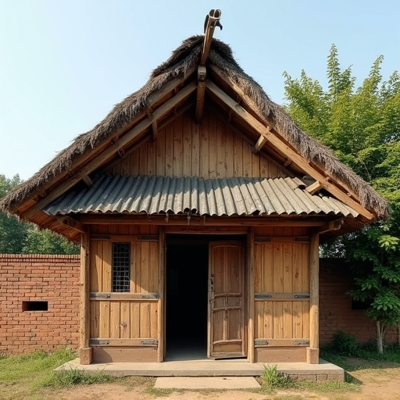

gen_text :  <|im_start|>The image shows a traditional wooden house with a pitched roof and a thatched roof. The house has a flat roof and is surrounded by lush greenery. There are two chimneys on the roof, and the door is open to the right side of the house. The house appears to be situated in a rural or semi-rural area, as indicated by the natural surroundings and the absence of people or vehicles in the scene.<|im_end|>
gt_text  :   A traditional thatched-roof hut with a wooden frame and a corrugated metal roof. The hut has a large open doorway with a metal gate, and there is a small window on the left side. The roof is supported by wooden beams and has a few decorative elements hanging from it. The hut is surrounded by a brick wall with a small opening, and there is a lush green bush to the right.


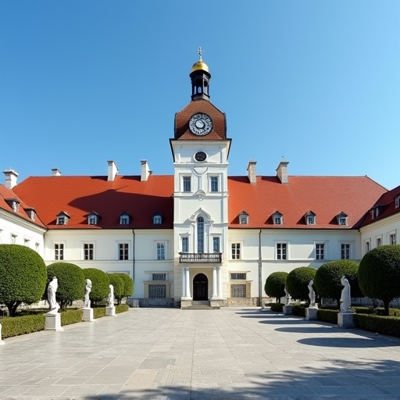

gen_text :  <|im_start|><|im_start|>The image shows a grand building with a clock tower, featuring a red roof. The building has multiple windows and is surrounded by lush greenery. There are several trees and bushes in the foreground, and the scene appears to be set against a clear blue sky.<|im_end|>
gt_text  :   A large, ornate building with a red-tiled roof and white walls is surrounded by a paved courtyard. The building features multiple windows with white frames and a prominent clock tower with a golden dome. Statues are placed around the courtyard, and the sky is clear and blue.


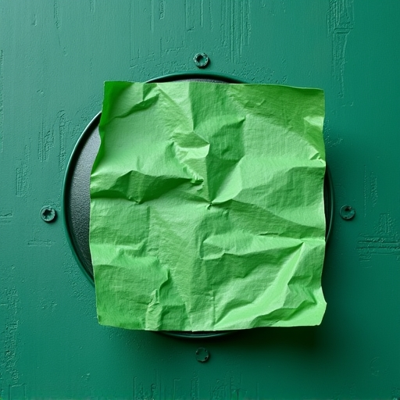

gen_text :  <|im_start|><|im_start|>The image shows a close-up of a piece of green paper with the word 'note' written on it. The paper is placed against a green background, and there is a small amount of white text underneath the paper, which reads 'descriptio'. The paper has a textured surface with a grid-like pattern. The background is a dark green color, and there are two screws visible in the bottom right corner.<|im_end|>
gt_text  :   A crumpled piece of green paper is stuck to the underside of a green surface, possibly a table or a roof. The paper is partially covered by a circular object, which appears to be a light fixture or a decorative element. The surface has a textured appearance with some areas appearing smoother than others.


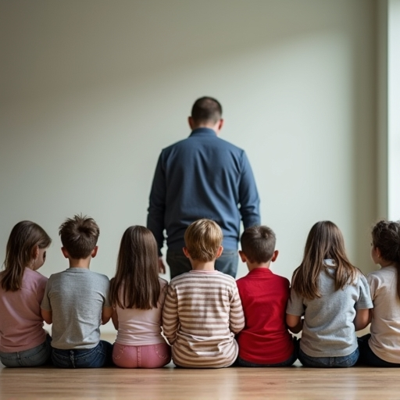

gen_text :  <|im_start|><|im_start|>The image shows a group of children gathered around a person who appears to be a teacher or guardian. The children are seated on the floor, and the person is standing in front of them, with their back to the camera. The children are wearing different colored shirts, and the person is wearing a blue jacket and gray pants. The background is a plain wall, and the scene seems to be set indoors, possibly a classroom or a similar setting.<|im_end|>
gt_text  :   The image features a group of children sitting in a row, with a man standing behind them. The text above them reads 'Physical abuse is no way to discipline a child, at home, at the school or institutional care. It infringes the child's self-worth and dignity.' The text below them says 'Discipline does not need a rod slap or kick. Teach the violence of love, the love of violence.' The image is part of a campaign against physical abuse and violence towards children.


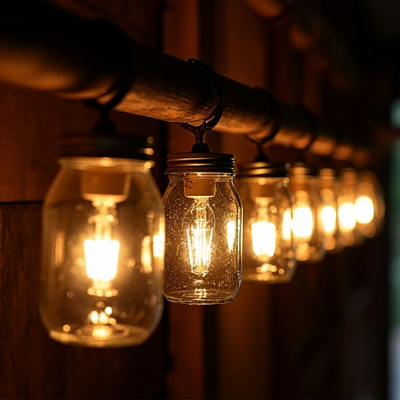

gen_text :  <|im_start|><|im_start|>The image shows a collection of hanging lights made of glass jars. Each jar has a metal wire connected to the ceiling, and the lights are turned on. The jars are arranged in a line, with some jars in the foreground and others in the background. The lighting is warm, casting a cozy atmosphere.<|im_end|>
gt_text  :   A collection of glass jars with metal lids, each containing a lit light bulb, are hanging from a wooden beam. The jars are of various sizes and are evenly spaced along the beam. The light bulbs inside the jars emit a warm, soft glow, and the scene is set against a dark background, highlighting the jars and their contents.


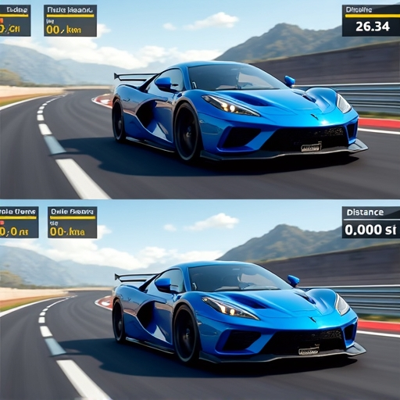

gen_text :  <|im_start|><|im_start|>The second image is a comparison between the first and the third image. The first image shows a blue sports car with a white roof on a track, with a speedometer showing the distance traveled. The second image is a comparison between the first and the third image, with the blue sports car being compared to the speedometer.<|im_end|>
gt_text  :   The second image shows the same racing game interface with the same blue sports car and racing track. However, the speedometer now displays '26.34 km/h' instead of '26.34 mph'. The 'Speed' meter has been replaced with a 'Distance' meter, which shows '0.0 km'. The 'Time' meter now displays '0.00 s'. The 'Lap' meter has been replaced with a 'Distance' meter, which shows '0.0 km'. The 'Laps' meter now displays '0.00 km'. The 'Fuel' meter has been replaced with a 'Distance'


In [34]:
for img, gt_text in zip(test_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

### 6.2. Train Samples

In [35]:
train_samples = hf_dataset_sampled['train'].shuffle().select(range(6))[:]

In [36]:
gt_texts = [d['prompt'] for d in train_samples['json']]

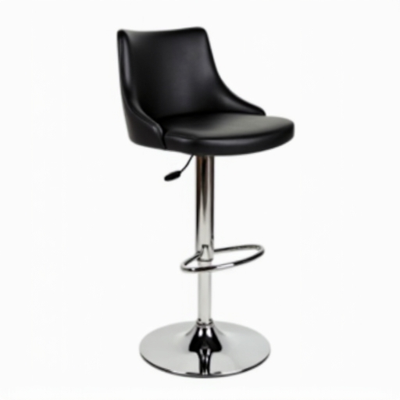

get_text :  <|im_start|><|im_start|><|im_start|>The image shows a close-up of a bar stool with a black leather seat and backrest. The stool has a chrome base and a round, curved metal footrest with a silver rim. The leather seats are smooth and unmarked, and the background is a plain white color.<|im_end|>
gt_text  :   A sleek modern bar stool with a black leather seat and backrest, a chrome base, and a round chrome footrest.


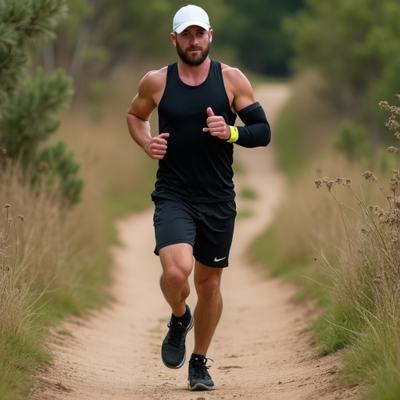

get_text :  <|im_start|><|im_start|>The image shows a person running on a dirt path in an outdoor setting with grass and trees. The individual is wearing a black tank top, black shorts, and a white cap. They are wearing black sneakers and have a yellow wristband on their left arm. The path is surrounded by dry vegetation and there is a clear view of the sky above.<|im_end|>
gt_text  :   A man is jogging on a dirt trail surrounded by grass and bushes. He is wearing a white cap, a black tank top, black shorts, and black running shoes. He has a black armband on his left arm and a yellow wristband on his right wrist.


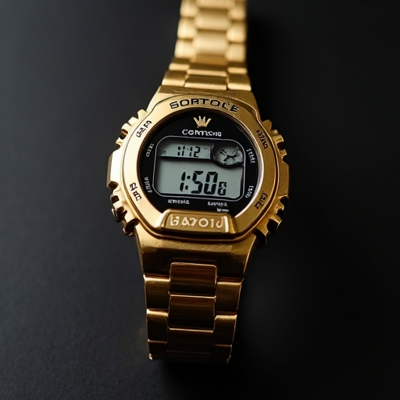

get_text :  <|im_start|><|im_start|><|im_start|>The image shows a close-up of a gold wristwatch with a black face and white text. The watch has a large, round dial with a date display at the top and a smaller date window below. The hands of the dial are black, and the watch is set against a dark background.<|im_end|>
gt_text  :   A gold wristwatch with a black face and a white digital display is lying on a dark surface. The watch has a gold band and a small, round, gold object attached to the side of the band.


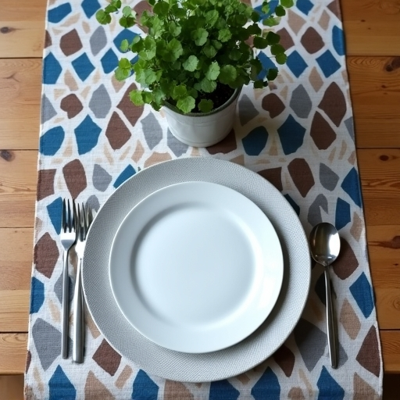

get_text :  <|im_start|><|im_start|><|im_start|>The image shows a dining table with a blue and white geometric patterned cloth laid out for a meal. There are two plates on the table, one with a white plate and a silver fork, and another with a white plate and a silver spoon. The table has a wooden surface with a textured finish, and there is a potted plant with green leaves placed on top of the cloth. The scene appears to be set for a meal, possibly a dinner or a brunch.<|im_end|>
gt_text  :   A wooden dining table with a blue and white geometric patterned tablecloth is set with a white plate, a silver fork, and a silver spoon. A potted plant with green leaves is placed on the table.


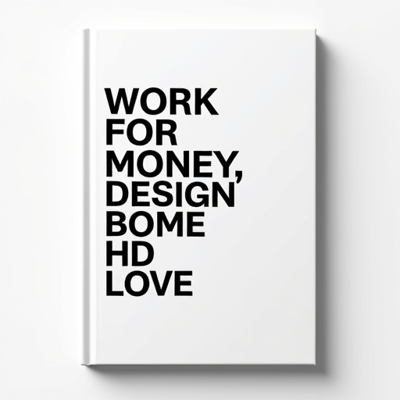

get_text :  <|im_start|><|im_start|><|im_start|>The image shows a white book cover with black text that reads 'WORK FOR MONEY, DESIGN FOR LOVE' in a bold, sans-serif font. The title is centered on the cover, and there are two smaller texts below it, 'WORK FOR MONEY' and 'DESIGN FOR LOVE', respectively. The background of the cover is plain white, and the book is displayed against this background.<|im_end|>
gt_text  :   A white book cover with black text that reads 'WORK FOR MONEY, DESIGN FOR LOVE' in a bold, sans-serif font. The text is centered on the cover, and there is no additional imagery or design elements.


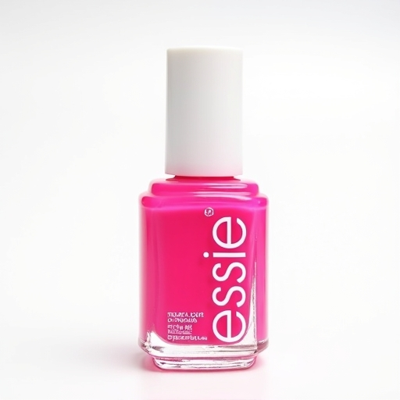

get_text :  <|im_start|><|im_start|><|im_start|>The image shows a close-up of a pink nail polish bottle with the label 'ESSIE' on it. The bottle is empty and has a white cap. The label features a graphic design with text and symbols, including a stylized letter 'E' and a stylized letter 'S'. The background is a plain white color.<|im_end|>
gt_text  :   A bottle of Essie nail polish with a white cap and a pink label. The label reads 'ESSIE' at the top and 'TREAT LOVE & COLOR' below it. The color of the polish is a vibrant pink. The bottle is placed against a white background.


In [37]:
for img, gt_text in zip(train_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

In [38]:
tokenizer, llm_model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name, load_8bit, load_4bit, attn_implementation=None)

{'device_map': 'auto', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
}


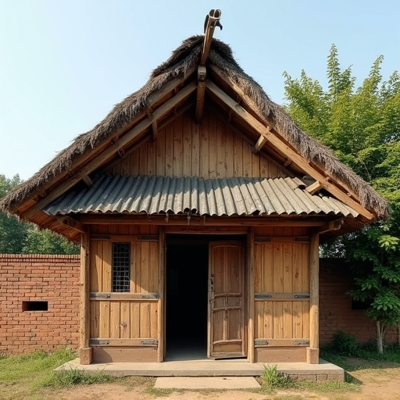

gen_text :  <|im_start|>The image captures a quaint wooden house nestled in the heart of a verdant landscape. The house, constructed from light-colored wood, is adorned with a thatched roof and a sloped roof, adding to its rustic charm. A sturdy door stands open on the left side of the house, inviting visitors into its warm embrace.

The house is surrounded by lush green trees, their leaves rustling gently in the breeze. These trees provide a natural backdrop to the house, creating a serene atmosphere. In the background, a brick wall stands tall, providing a stark contrast to the soft hues of the tree's foliage.

The ground beneath the house is covered in grass, suggesting a well-maintained garden or park. The overall scene paints a picture of tranquility and simplicity, where nature and architecture coexist harmoniously.<|im_end|>
gt_text  :   A traditional thatched-roof hut with a wooden frame and a corrugated metal roof. The hut has a large open doorway with a metal gate, and there 

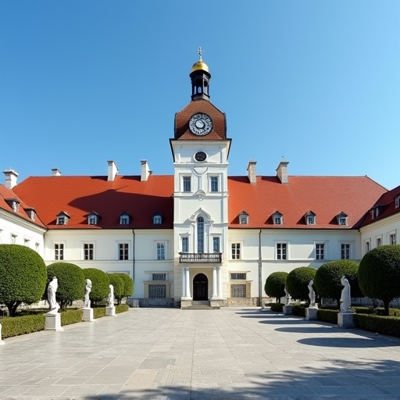

gen_text :  <|im_start|>The image shows a grand building with a red roof and a clock tower. The building has multiple windows, some of which are arched, suggesting it might be an older structure or possibly a historical site. There is a large, open courtyard in the center of the building that leads to a small, enclosed area with trees on either side. The sky above is clear blue, indicating good weather conditions. The overall style of the building suggests it could be a castle or a historic edifice, but without more specific details, it's difficult to determine its exact function or purpose.<|im_end|>
gt_text  :   A large, ornate building with a red-tiled roof and white walls is surrounded by a paved courtyard. The building features multiple windows with white frames and a prominent clock tower with a golden dome. Statues are placed around the courtyard, and the sky is clear and blue.


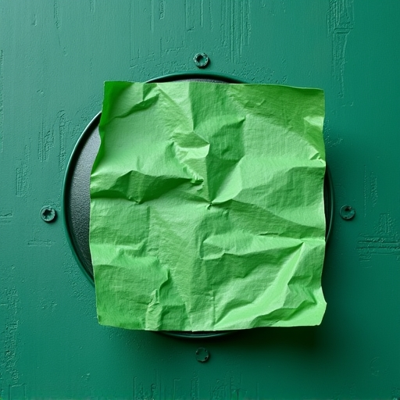

gen_text :  <|im_start|>The image shows a close-up view of a green piece of paper with a hole in the center. The paper appears to be torn or ripped, revealing the underlying material underneath. The background is a solid color, which contrasts with the bright green of the paper and makes it stand out prominently. There are no visible texts, logos, or other distinguishing marks on the paper. The style of the photograph is realistic, capturing the texture and form of the paper as it is exposed without any filters or artistic effects applied.<|im_end|>
gt_text  :   A crumpled piece of green paper is stuck to the underside of a green surface, possibly a table or a roof. The paper is partially covered by a circular object, which appears to be a light fixture or a decorative element. The surface has a textured appearance with some areas appearing smoother than others.


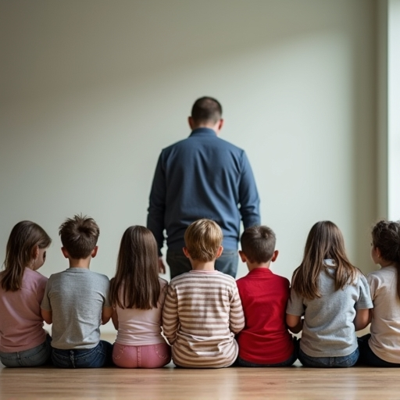

gen_text :  <|im_start|>In the center of a room with white walls, a group of children are gathered. They are seated on a wooden floor that extends across the room. The children vary in age from toddlers to teenagers, and they all wear matching clothing consisting of shirts and pants. The children's faces are not visible due to their proximity to the adult.

The adult, dressed in a blue jacket, stands behind the children. He is positioned towards the right side of the image. His stance suggests he might be leading or supervising the children.

The room itself has a plain wall, providing a neutral backdrop for the scene. A window can be seen in the background, allowing natural light into the room. The overall atmosphere appears calm and serene, typical of a quiet afternoon at home.<|im_end|>
gt_text  :   The image features a group of children sitting in a row, with a man standing behind them. The text above them reads 'Physical abuse is no way to discipline a child, at home, at the schoo

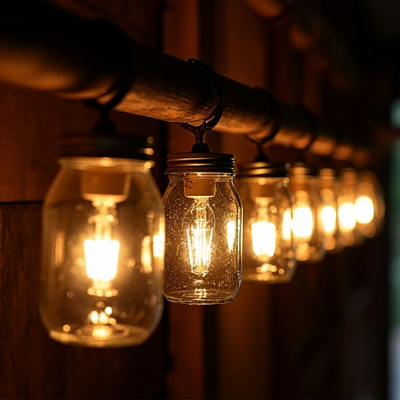

gen_text :  <|im_start|>The image captures a serene scene. Dominating the frame is a row of jars, each adorned with a single light bulb. The jars are arranged in a straight line, their glass bodies reflecting the soft glow of the lights. Each jar is identical in size and shape, their transparent surfaces revealing the intricate designs within.

The jars are not alone; they are connected by a series of pipes that run horizontally across the image. These pipes, made of wood, add an rustic charm to the otherwise modern setting. They lead up to a wooden ceiling, which is painted white, providing a stark contrast against the warm yellow hue of the lanterns.

Despite being illuminated, the jars maintain their position, standing as silent sentinels amidst the ambient light. Their positions relative to one another create a sense of balance, while their connection to the pipe creates a harmonious interplay between light and shadow.

Overall, this image paints a picture of simplicity and tranqui

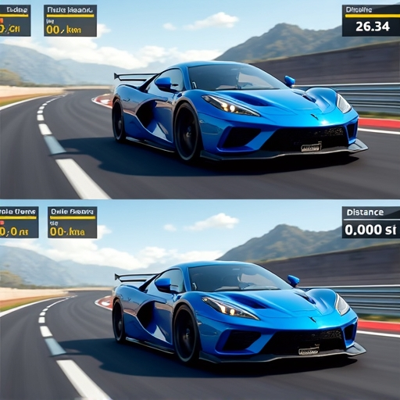

gen_text :  <|im_start|>The image is a composite of two identical frames, each showing the same blue sports car on a track. The left frame shows the car from an overhead perspective, while the right frame presents it from below. Both frames have similar elements such as the track surface, speedometer, and other racing-related graphics. The background consists of a mountainous landscape with clear skies. There are no visible texts or subtitles in the images.<|im_end|>
gt_text  :   The second image shows the same racing game interface with the same blue sports car and racing track. However, the speedometer now displays '26.34 km/h' instead of '26.34 mph'. The 'Speed' meter has been replaced with a 'Distance' meter, which shows '0.0 km'. The 'Time' meter now displays '0.00 s'. The 'Lap' meter has been replaced with a 'Distance' meter, which shows '0.0 km'. The 'Laps' meter now displays '0.00 km'. The 'Fuel' meter has been replaced with a 'Distance'


In [39]:
for img, gt_text in zip(test_samples['jpg'], [d['prompt'] for d in test_samples['json']]):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

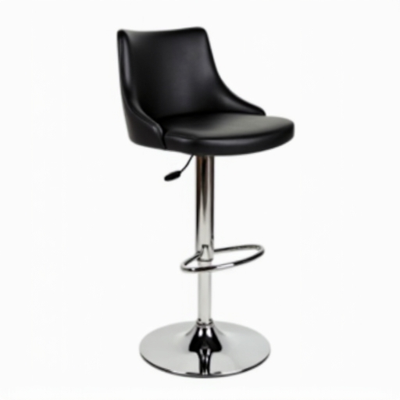

get_text :  <|im_start|>This image shows a black stool with chrome legs and a curved top. The stool has a modern design, featuring a contoured backrest that curves slightly upwards at the base. It appears to be made of a durable material, possibly leather or a similar synthetic fabric. The legs are sturdy and appear to be made of metal, likely stainless steel, which gives it a sleek appearance. There is no visible branding or text on the stool. The stool's design suggests it could be used for various purposes such as sitting down, standing up, or even being used as a bar stool.<|im_end|>
gt_text  :   A sleek modern bar stool with a black leather seat and backrest, a chrome base, and a round chrome footrest.


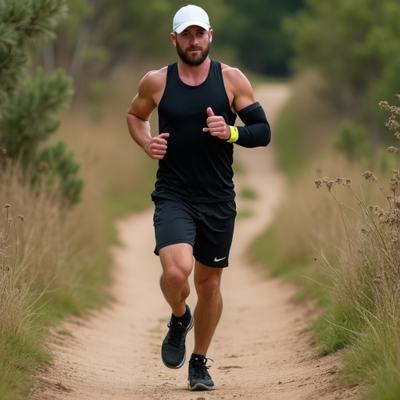

get_text :  <|im_start|>In the image, there is a person who appears to be jogging. The individual is wearing black shorts and a black tank top with white text on it. They are also wearing black shoes that have white soles. In their right hand, they are holding a yellow wristband. The person is running along a dirt path surrounded by tall grasses. The background of the image shows trees and bushes, suggesting an outdoor setting. There are no other objects or people in the immediate vicinity of the person jogging. The lighting in the image is natural, indicating that it was taken during the day.<|im_end|>
gt_text  :   A man is jogging on a dirt trail surrounded by grass and bushes. He is wearing a white cap, a black tank top, black shorts, and black running shoes. He has a black armband on his left arm and a yellow wristband on his right wrist.


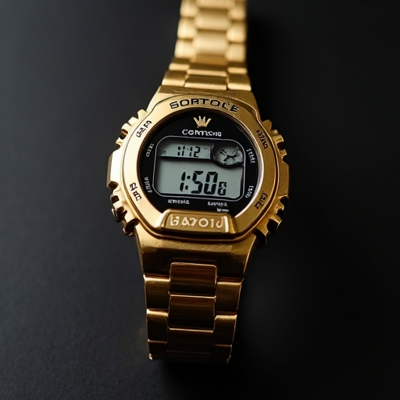

get_text :  <|im_start|>This is a digital image of a wristwatch. The watch has a gold band with silver details and a black face. It has Roman numerals on the clock, indicating that it's showing 5:20. There are no visible texts or logos on the watch face. The watch appears to be made of metal, possibly stainless steel, given its shine and color. The background is a solid dark color, which contrasts with the watch and makes it stand out. The style of the image is straightforward and clear, focusing on the watch without any distractions.<|im_end|>
gt_text  :   A gold wristwatch with a black face and a white digital display is lying on a dark surface. The watch has a gold band and a small, round, gold object attached to the side of the band.


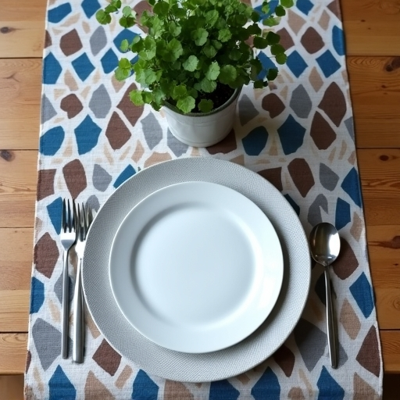

get_text :  <|im_start|>The image captures a serene dining scene. At the center of the frame, a white plate with a black border and a silver fork rests on a blue and brown geometric patterned tablecloth. The plate is adorned with a single green leaf, adding a touch of nature to the otherwise monochrome setting.

To the right of the plate, a small potted plant with dark green leaves stands tall. Its presence brings a sense of life and tranquility to the scene.

On the left side of the plate, there's a small white pot filled with earthy tones. It's nestled next to a small black pot, both contributing to the overall rustic charm of the setting.

In the background, a wooden table stretches out, its surface covered in a light blue cloth that matches the tablecloth used for the plate and the plant. This contrast creates a harmonious balance within the scene.

Overall, this image paints a picture of a peaceful mealtime, where each element has been thoughtfully placed to create an inviting and

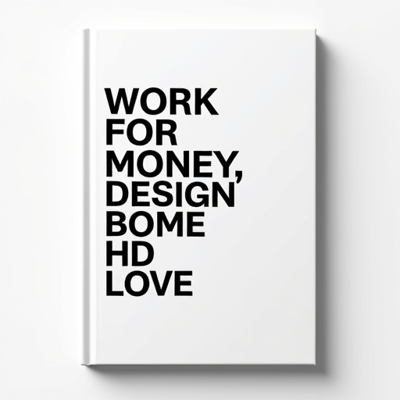

get_text :  <|im_start|>This is a white book cover with black text. The title "WORK FOR MONEY, DESIGN BOOME HD LOVE" is written in bold, capitalized letters at the top of the page. Below this, there are four lines of text: "Money," "Design," "Boome," and "Love." The words are arranged in a staggered fashion, starting from the top left corner and moving down to the bottom right corner. The overall style of the image suggests that it might be related to business or entrepreneurship, possibly discussing how money can be used for personal projects like designing and creating content.<|im_end|>
gt_text  :   A white book cover with black text that reads 'WORK FOR MONEY, DESIGN FOR LOVE' in a bold, sans-serif font. The text is centered on the cover, and there is no additional imagery or design elements.


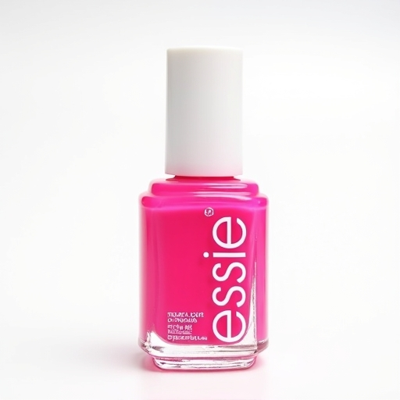

get_text :  <|im_start|>This is a product image of an Essie nail polish bottle. The bottle has a white cap and the label is visible with text on it, which includes "ESSIE" in large letters at the top, followed by the word "NAIL POLISH" below it. Below this, there are two lines of text that read "ELASTIC STONE," "EASY TO application," and "WET PAINT." There's also a small logo or emblem in the bottom right corner. The background behind the bottle is plain white, emphasizing the product.<|im_end|>
gt_text  :   A bottle of Essie nail polish with a white cap and a pink label. The label reads 'ESSIE' at the top and 'TREAT LOVE & COLOR' below it. The color of the polish is a vibrant pink. The bottle is placed against a white background.


In [40]:
for img, gt_text in zip(train_samples['jpg'], [d['prompt'] for d in train_samples['json']]):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('get_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)